In [167]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import librosa
from tqdm import tqdm
from IPython.display import Audio
from pandas.api.types import is_numeric_dtype

import sys
sys.path.append('../')
import default_style

TS_DATASET_FOLDER = os.path.join("..", "dataset")
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, "preprocessed_traces")
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, "preproc_ts.df")

INTERESTING_TRACES = [ "std_phon_trace", "clean_trace"]


df = pd.read_csv(DF_PREPROC_FILE)
traces = dict()
for t in INTERESTING_TRACES:
    traces[t] = np.load(os.path.join(TS_PREPROC_FOLDER, f"{t}.npy"), allow_pickle=True)

# traces["syll_labels"] = np.repeat(np.arange(7), len(traces["syllables_fourier"])//7)
# print(traces["syll_labels"].shape)

SAMPLING_RATE = 48_000/8

## Short-time Fourier transform

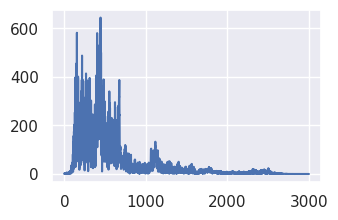

In [164]:
from scipy.fft import fft, ifft, fftfreq

signal = traces["clean_trace"][6]
signal = signal[~np.isnan(signal)]

N, T = len(signal), 1.0/SAMPLING_RATE

spectrum = np.abs(fft(signal)[:N//2])
freqs = fftfreq(N, T)[:N//2]

plt.plot(freqs, spectrum)

Audio split in 50 windows
Each window is 48.50 millisec long
Max frequency is 3.0 kHz


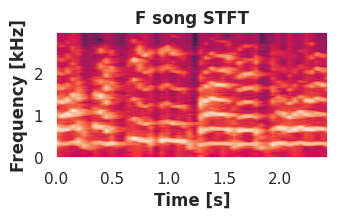

In [160]:
track_index = 1500
signal = traces["clean_trace"][track_index]
signal = signal[~np.isnan(signal)]

M, N, T = 50, len(signal), 1.0/SAMPLING_RATE

windows = np.array_split(signal, M)
winlen = np.min([len(w) for w in windows])

print(f"Audio split in {len(windows)} windows")
print(f"Each window is {winlen/SAMPLING_RATE*1e3:.2f} millisec long")
print(f"Max frequency is {np.max(freqs)*1e-3:.1f} kHz")

STFT = np.zeros((winlen//2, M))

for i, part in enumerate(windows):
    regularized_window = np.hamming(len(part))*part
    window_spectrum = np.abs(fft(regularized_window)[:winlen//2])
    STFT[:winlen//2, i] = np.log(window_spectrum)
    
TT, FF = np.linspace(0, N/SAMPLING_RATE, M), fftfreq(winlen, T)[:winlen//2]*1e-3

TT, FF = np.meshgrid(TT, FF)    
plt.contourf(TT.T, FF.T, STFT.T, levels=100)

plt.grid(ls="")
# plt.axis("off")
plt.xlabel("Time [s]");
plt.ylabel("Frequency [kHz]");
plt.title(f"{df.sex[track_index]} {df.vocal_channel[track_index]} STFT");

## Spectral statistics timeseries

Since the stft returns a matrix (bad), It is possible to extract a statictical feature from the spectrum of each window, such as the spectral centroid

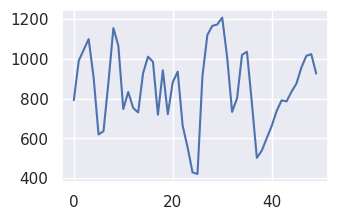

In [161]:
stft_centroid = np.zeros(M)
TT, FF = np.linspace(0, N/SAMPLING_RATE, M), fftfreq(winlen, T)[:winlen//2]

for i in range(M):
    # get a distribution from STFT
    energy_density = np.exp(STFT[:, i]) - np.min(np.exp(STFT[:, i])) # offsets the minimum to be zero
    energy_density /= np.sum(energy_density)         # normalizes
#     plt.plot(FF, energy_density)

    # gets weighted mean
    stft_centroid[i] = np.sum(FF*energy_density)
    
plt.plot(stft_centroid)

## For the full dataset

In [194]:
traces["spectral_centroid"] = []
traces["spectral_mode"] = []

for tr in tqdm(traces["clean_trace"]):
    
    # Removes padding
    signal = tr[~np.isnan(tr)]
    
    # Gets values of stuff
    M, N, T = 50, len(signal), 1.0/SAMPLING_RATE

    windows = np.array_split(signal, M)
    winlen = np.min([len(w) for w in windows])

    STFT_CENTROID = np.zeros(M)
    STFT_MODE = np.zeros(M)
    FF = fftfreq(winlen, T)[:winlen//2]

    for i, part in enumerate(windows):
        regularized_window = np.hamming(len(part))*part
        window_spectrum = np.abs(fft(regularized_window)[:winlen//2])**2
        
        # Gets distribution
        energy_density = window_spectrum/np.sum(window_spectrum)
        
        # Gets weighted mean
        STFT_CENTROID[i] = np.sum(energy_density*FF)
        
        # Gets argmax (i.e. the mode)
        STFT_MODE[i] = FF[np.argmax(energy_density)]
    
    traces["spectral_centroid"].append(STFT_CENTROID)
    traces["spectral_mode"].append(STFT_MODE)

# Makes them array
traces["spectral_centroid"] = np.array(traces["spectral_centroid"])
traces["spectral_mode"] = np.array(traces["spectral_mode"])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2452/2452 [00:16<00:00, 147.12it/s]


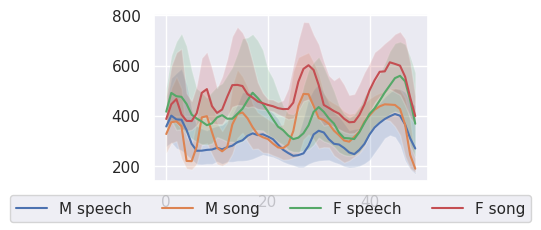

In [195]:
fig, ax = plt.subplots()
for s in ["M", "F"]:
    for vc in ["speech","song"]:
        subsamp = traces["spectral_centroid"][(df.vocal_channel == vc)&(df.sex==s)]
        low, mid, upp = np.quantile(subsamp, [.25, .5, .75], axis=0)
        
        plt.plot(mid, label=f"{s} {vc}")
        plt.fill_between(range(50), low, upp,alpha=0.2)
fig.legend(ncols = 4, loc="lower center")

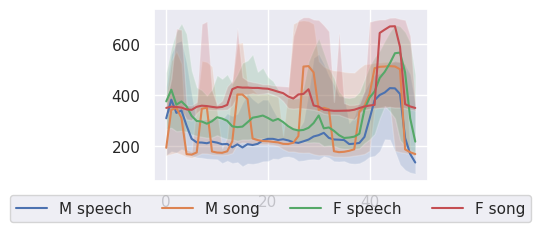

In [196]:
fig, ax = plt.subplots()
for s in ["M", "F"]:
    for vc in ["speech","song"]:
        subsamp = traces["spectral_mode"][(df.vocal_channel == vc)&(df.sex==s)]
        low, mid, upp = np.quantile(subsamp, [.25, .5, .75], axis=0)
        
        plt.plot(mid, label=f"{s} {vc}")
        plt.fill_between(range(50), low, upp,alpha=0.2)
fig.legend(ncols = 4, loc="lower center")

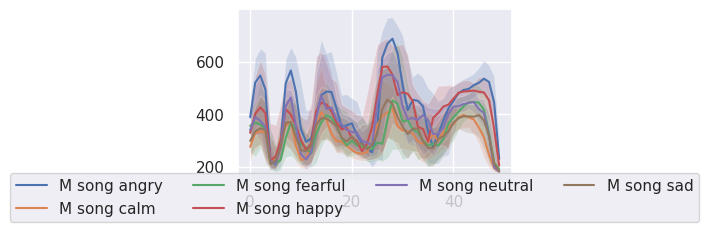

In [197]:
fig, ax = plt.subplots()
for s in ["M"]:
    for vc in ["song"]:
        for emo in np.unique(df[(df.sex==s)&(df.vocal_channel == vc)].emotion):
        
            subsamp = traces["spectral_centroid"][(df.vocal_channel == vc)&(df.sex==s)&(df.emotion==emo)]
            low, mid, upp = np.quantile(subsamp, [.25, .5, .75], axis=0)

            plt.plot(mid, label=f"{s} {vc} {emo}")
            plt.fill_between(range(50), low, upp,alpha=0.2)
fig.legend(ncols = 4, loc="lower center")

In [198]:
for t in ["spectral_centroid", "spectral_mode"]:
    np.save(os.path.join(TS_PREPROC_FOLDER, f"{t}.npy"), traces[t])